In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=[FutureWarning,UserWarning])
import missingno as msno
import numpy as np 
from sklearn.model_selection import KFold,GridSearchCV,train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import PowerTransformer,MinMaxScaler
from sklearn import datasets
from sklearn.svm import SVC
import scipy.stats as stats
from sklearn.metrics import recall_score,precision_score,accuracy_score,f1_score
import time

In [2]:
dataload=datasets.load_iris()


data = pd.DataFrame(data = dataload['data'], columns = dataload['feature_names'])
data['type'] = dataload['target']


In [3]:
data.head()
dataYedek=data.copy()
target="type"

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   type               150 non-null    int64  
dtypes: float64(4), int64(1)
memory usage: 6.0 KB


In [5]:
data.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),type
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


<Axes: >

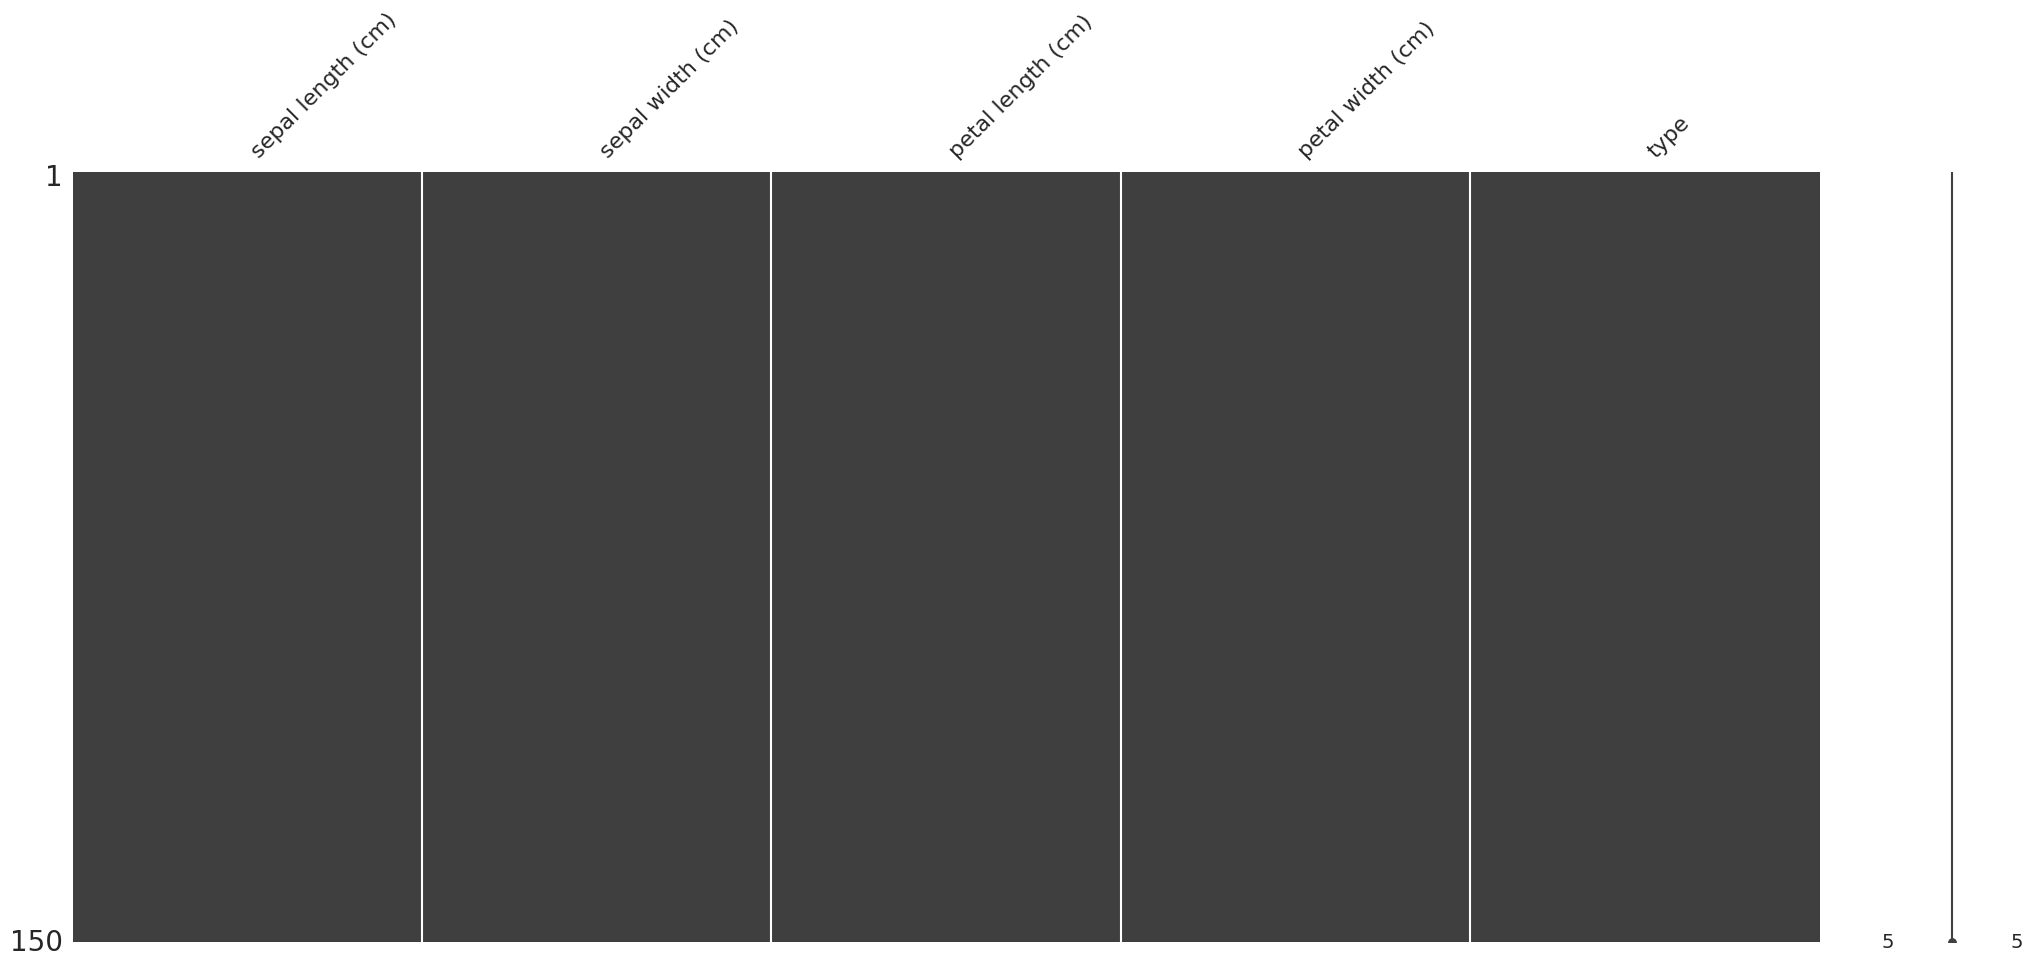

In [6]:
msno.matrix(data)


<Axes: >

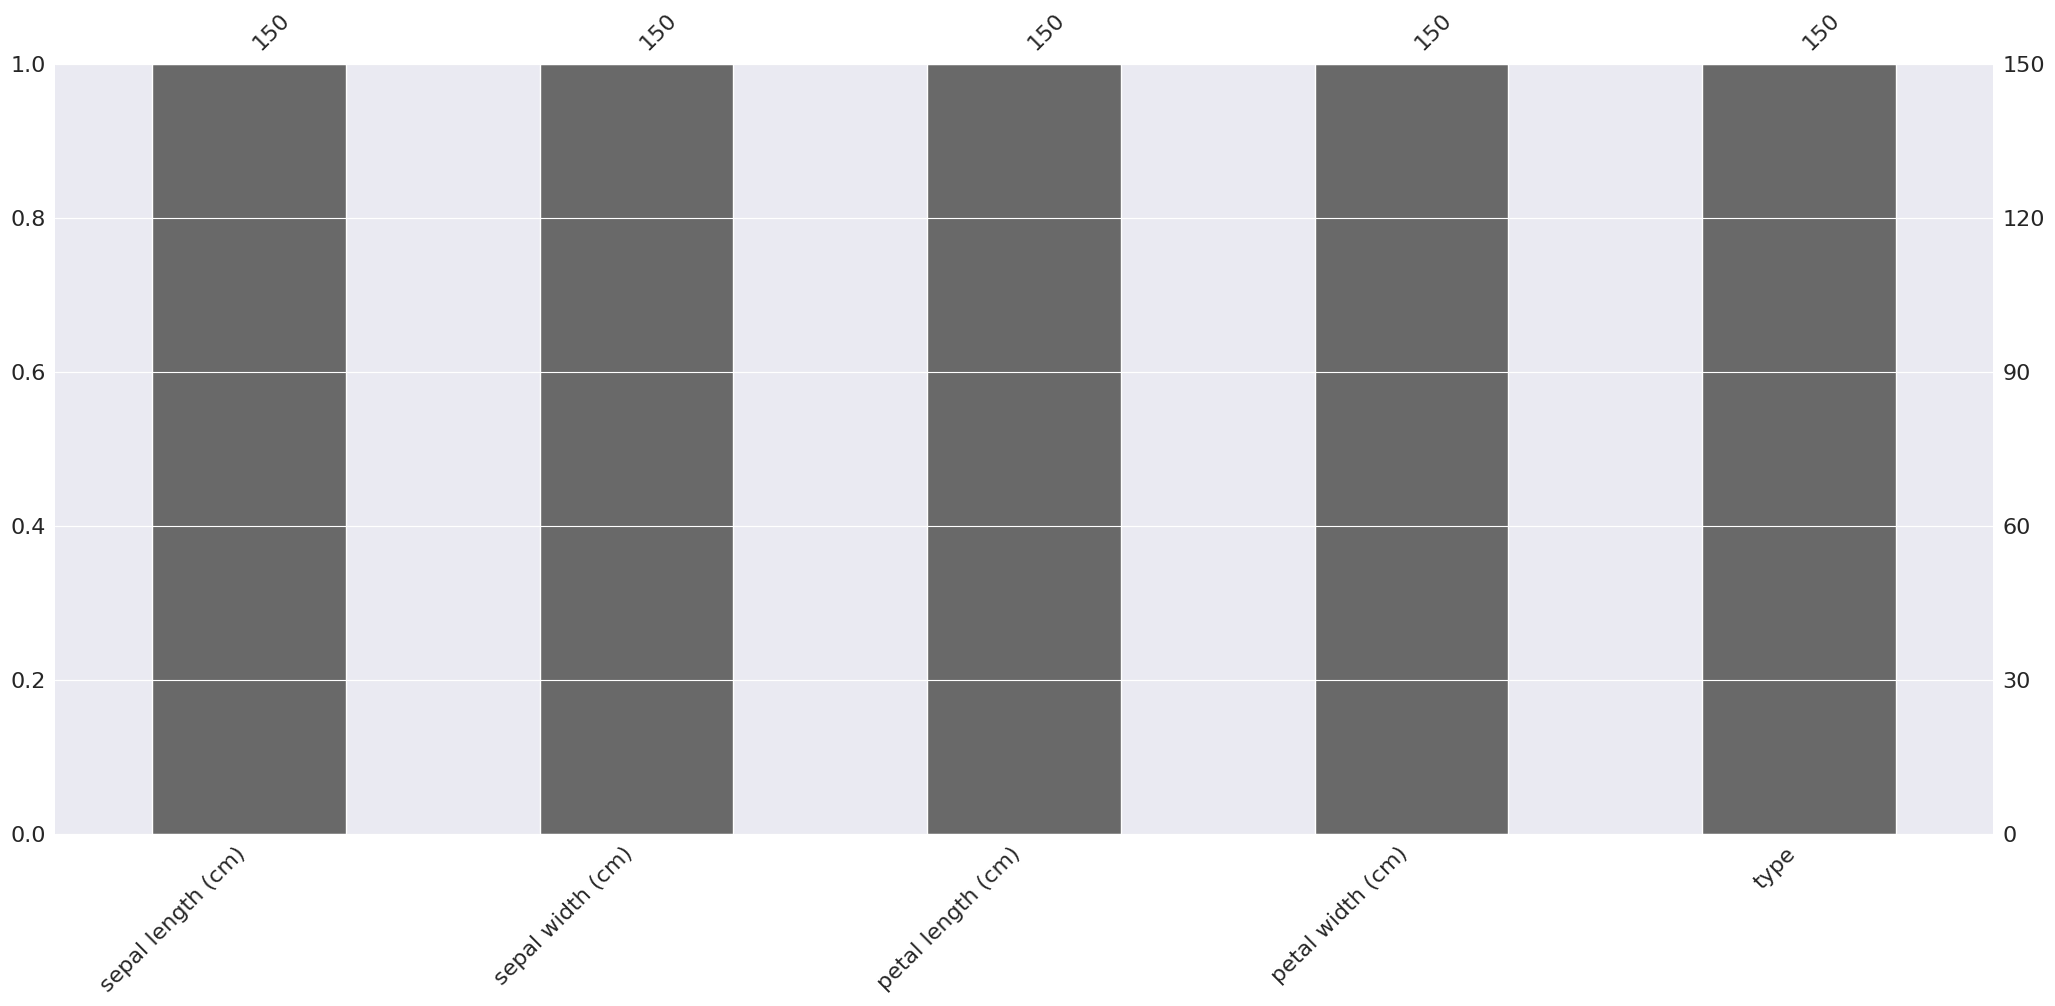

In [7]:
msno.bar(data)


In [8]:
data[target].value_counts()

type
0    50
1    50
2    50
Name: count, dtype: int64

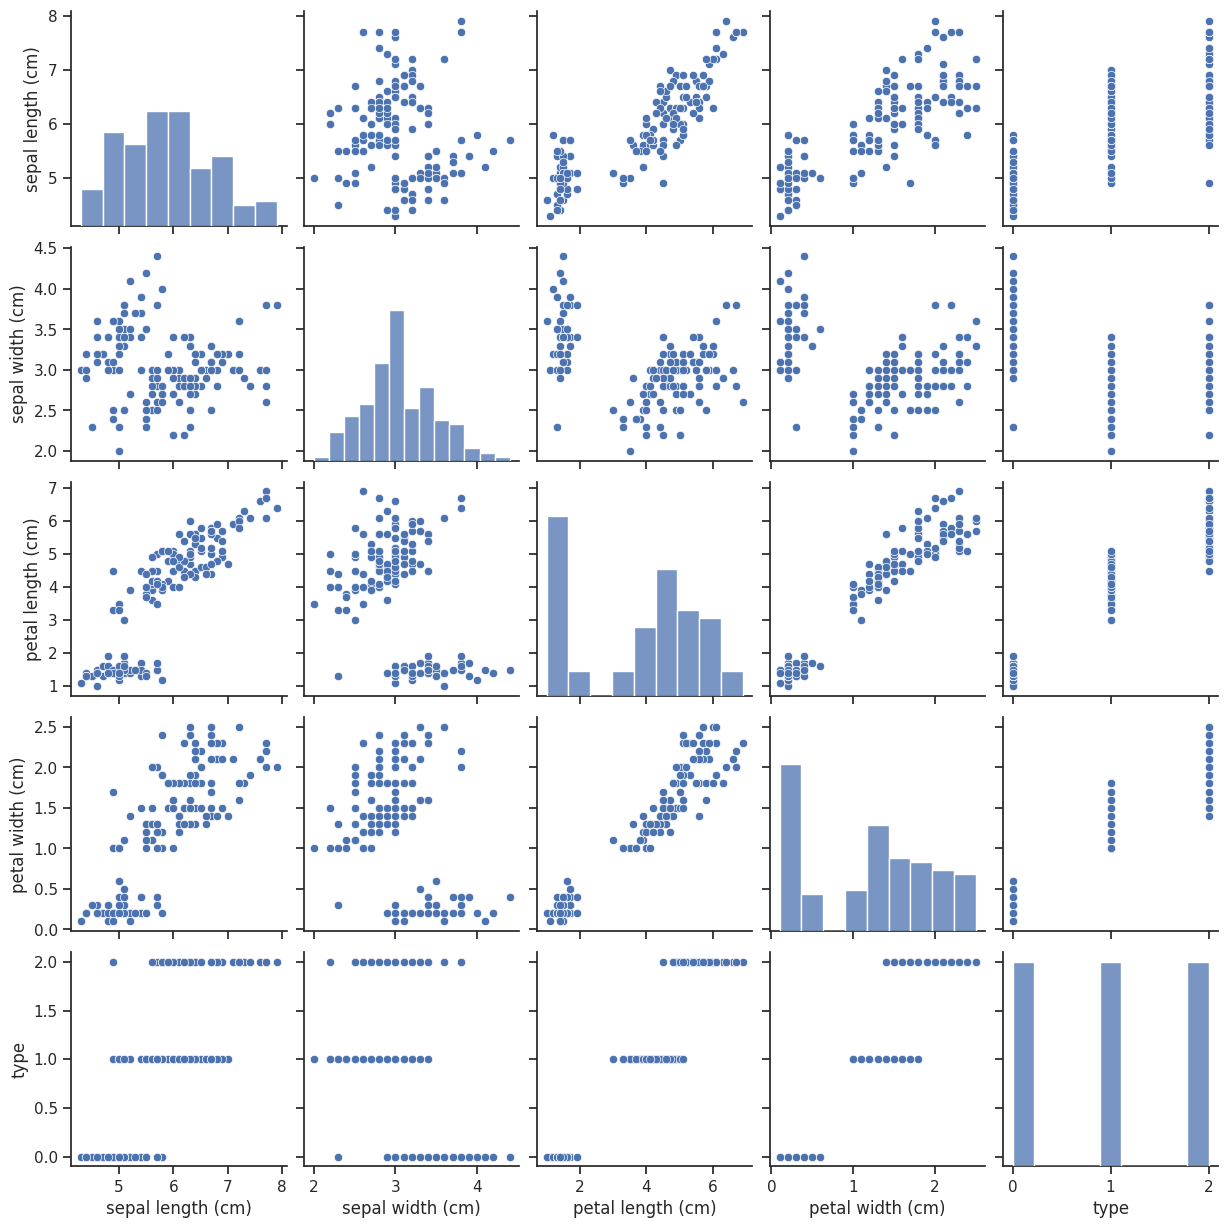

In [9]:
sns.set_theme(style="ticks")
sns.pairplot(data)

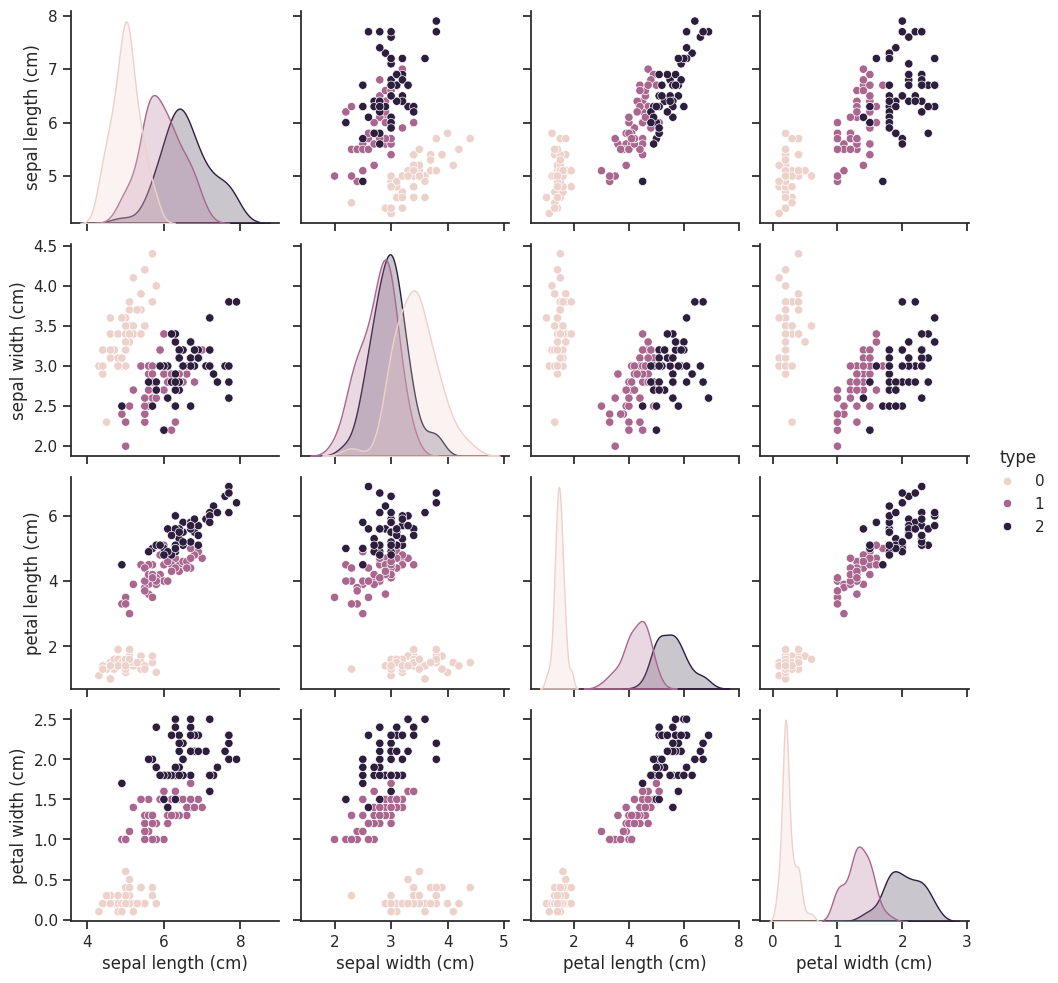

In [10]:
sns.set_theme(style="ticks")
sns.pairplot(data, hue=target)

In [11]:
data.shape

(150, 5)

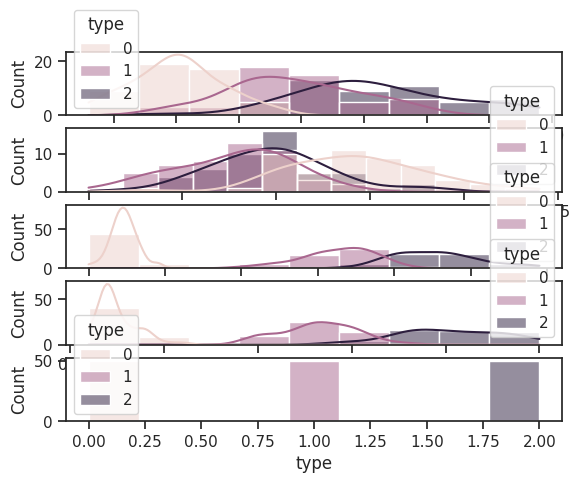

In [12]:
fix, ax = plt.subplots(nrows=5, ncols=1)
for i,column in enumerate(data.columns):
    sns.histplot(data,x=column,kde=True,ax=ax[i],hue=target)

In [13]:
indexesTarget0=[]
tableTarget0 = {"Statistic": [], "p-value": []}
indexesTarget1=[]
tableTarget1 = {"Statistic": [], "p-value": []}
columns=data.columns.tolist()
columns.remove(target)
for i in columns:
    newData=data[[i,target]].groupby(target)
    result0=newData.apply(stats.shapiro)
    tableTarget0["Statistic"].append(result0.loc[0][0])
    tableTarget0["p-value"].append(result0.loc[0][1])
    indexesTarget0.append(i)
    result1=newData.apply(stats.shapiro)
    tableTarget1["Statistic"].append(result1.loc[1][0])
    tableTarget1["p-value"].append(result1.loc[1][1])
    indexesTarget1.append(i)
shapiroResultsTarget0 = pd.DataFrame(tableTarget0,index=indexesTarget0)
shapiroResultsTarget1 = pd.DataFrame(tableTarget1,index=indexesTarget1)

In [14]:
shapiroResultsTarget0

,Statistic,p-value
sepal length (cm),0.977699,4.595131e-01
sepal width (cm),0.971720,2.715264e-01
petal length (cm),0.954977,5.481147e-02
petal width (cm),0.799764,8.658573e-07


In [15]:
shapiroResultsTarget1

,Statistic,p-value
sepal length (cm),0.977836,0.464737
sepal width (cm),0.974133,0.337995
petal length (cm),0.966004,0.158478
petal width (cm),0.947626,0.027278


In [16]:
def featureTransformations(data,target,columnsNeedTransformation):
    columnsList=[]
    def apply_boxcox(group):
        pt = PowerTransformer(method="box-cox")
        transformed_values = pt.fit_transform(group[[i]])
        group[i+'_transformed'] = transformed_values
        return group
    def apply_yj(group):
        pt = PowerTransformer()
        transformed_values = pt.fit_transform(group[[i]])
        group[i+'_transformed'] = transformed_values
        return group
    for i in columnsNeedTransformation:
        columnsList+=[i+j for j in ["Reciprocal","SquareRoot","Log","YeoJohnson","BoxCox"]]
    normalizedData=pd.DataFrame(columns=columnsList)
    for i in columnsNeedTransformation:
        normalizedData[i+"SquareRoot"]=data[[i,target]].groupby(target).transform(np.sqrt)
        if min(data[i])>0:
            normalizedData[i+"BoxCox"]= data[[i,target]].groupby(target).apply(apply_boxcox).reset_index( level = [0] ).sort_index()[i+'_transformed']
            normalizedData[i + "Reciprocal"] = data[[i,target]].groupby(target).transform(lambda x: 1 / x)
            normalizedData[i + "Log"] = data[[i,target]].groupby(target).transform(np.log)
        else:
            temp=pd.DataFrame(columns=[i,target])
            temp[i]=data[i]+np.abs(min(data[i]))+0.00000000000001
            temp[target]=data[target]
            normalizedData[i+"BoxCox"]=temp[[i,target]].groupby(target).apply(apply_boxcox).reset_index( level = [0] ).sort_index()[i+'_transformed']
        normalizedData[i+"YeoJohnson"]=data[[i,target]].groupby(target).apply(apply_yj).reset_index( level = [0] ).sort_index()[i+'_transformed']
    normalizedData=normalizedData.dropna(axis=1)
    return normalizedData

In [17]:
newData2=featureTransformations(data,target,columns)
newData2[target]=data[target]

In [18]:
newData2

,sepal length (cm)Reciprocal,sepal length (cm)SquareRoot,sepal length (cm)Log,sepal length (cm)YeoJohnson,sepal length (cm)BoxCox,sepal width (cm)Reciprocal,sepal width (cm)SquareRoot,sepal width (cm)Log,sepal width (cm)YeoJohnson,sepal width (cm)BoxCox,...,petal length (cm)SquareRoot,petal length (cm)Log,petal length (cm)YeoJohnson,petal length (cm)BoxCox,petal width (cm)Reciprocal,petal width (cm)SquareRoot,petal width (cm)Log,petal width (cm)YeoJohnson,petal width (cm)BoxCox,type
0,0.196078,2.258318,1.629241,0.291753,0.291952,0.285714,1.870829,1.252763,0.193799,0.192850,...,1.183216,0.336472,-0.351279,-0.352651,5.000000,0.447214,-1.609438,-0.325106,-0.305645,0
1,0.204082,2.213594,1.589235,-0.281966,-0.281625,0.333333,1.732051,1.098612,-1.141075,-1.140797,...,1.183216,0.336472,-0.351279,-0.352651,5.000000,0.447214,-1.609438,-0.325106,-0.305645,0
2,0.212766,2.167948,1.547563,-0.872041,-0.871811,0.312500,1.788854,1.163151,-0.606220,-0.606871,...,1.140175,0.262364,-0.941101,-0.940917,5.000000,0.447214,-1.609438,-0.325106,-0.305645,0
3,0.217391,2.144761,1.526056,-1.173541,-1.173507,0.322581,1.760682,1.131402,-0.873492,-0.873753,...,1.224745,0.405465,0.231102,0.229329,5.000000,0.447214,-1.609438,-0.325106,-0.305645,0
4,0.200000,2.236068,1.609438,0.006876,0.007168,0.277778,1.897367,1.280934,0.459897,0.459130,...,1.183216,0.336472,-0.351279,-0.352651,5.000000,0.447214,-1.609438,-0.325106,-0.305645,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,0.149254,2.588436,1.902108,0.196076,0.195857,0.333333,1.732051,1.098612,0.131337,0.130527,...,2.280351,1.648659,-0.595339,-0.594302,0.434783,1.516575,0.832909,1.011126,1.011193,2
146,0.158730,2.509980,1.840550,-0.442478,-0.442519,0.400000,1.581139,0.916291,-1.563440,-1.561834,...,2.236068,1.609438,-1.053968,-1.053377,0.526316,1.378405,0.641854,-0.483413,-0.481592,2
147,0.153846,2.549510,1.871802,-0.121271,-0.121418,0.333333,1.732051,1.098612,0.131337,0.130527,...,2.280351,1.648659,-0.595339,-0.594302,0.500000,1.414214,0.693147,-0.119225,-0.116698,2
148,0.161290,2.489980,1.824549,-0.604578,-0.604557,0.294118,1.843909,1.223775,1.307486,1.306948,...,2.323790,1.686399,-0.176819,-0.175972,0.434783,1.516575,0.832909,1.011126,1.011193,2


In [19]:
indexesTarget0=[]
tableTarget0 = {"Statistic": [], "p-value": []}
indexesTarget1=[]
tableTarget1 = {"Statistic": [], "p-value": []}
columns=newData2.columns.tolist()
columns.remove(target)
for i in columns:
    newData=newData2[[i,target]].groupby(target)
    result0=newData.apply(stats.shapiro)
    tableTarget0["Statistic"].append(result0.loc[0][0])
    tableTarget0["p-value"].append(result0.loc[0][1])
    indexesTarget0.append(i)
    result1=newData.apply(stats.shapiro)
    tableTarget1["Statistic"].append(result1.loc[1][0])
    tableTarget1["p-value"].append(result1.loc[1][1])
    indexesTarget1.append(i)
shapiroResultsTarget0 = pd.DataFrame(tableTarget0,index=indexesTarget0)
shapiroResultsTarget1 = pd.DataFrame(tableTarget1,index=indexesTarget1)

In [20]:
pd.set_option('display.max_rows', shapiroResultsTarget0.shape[0]+1)

display(shapiroResultsTarget0)

,Statistic,p-value
sepal length (cm)Reciprocal,0.975013,3.653777e-01
sepal length (cm)SquareRoot,0.978425,4.876187e-01
sepal length (cm)Log,0.978214,4.793536e-01
sepal length (cm)YeoJohnson,0.978448,4.885309e-01
sepal length (cm)BoxCox,0.978453,4.887295e-01
sepal width (cm)Reciprocal,0.919934,2.344964e-03
sepal width (cm)SquareRoot,0.967606,1.846360e-01
sepal width (cm)Log,0.957914,7.269374e-02
sepal width (cm)YeoJohnson,0.971605,2.686840e-01
sepal width (cm)BoxCox,0.971659,2.700082e-01


In [21]:
pd.set_option('display.max_rows', shapiroResultsTarget0.shape[0]+1)

display(shapiroResultsTarget1)

,Statistic,p-value
sepal length (cm)Reciprocal,0.973557,0.321001
sepal length (cm)SquareRoot,0.978625,0.495560
sepal length (cm)Log,0.978197,0.478682
sepal length (cm)YeoJohnson,0.978626,0.495569
sepal length (cm)BoxCox,0.978639,0.496103
sepal width (cm)Reciprocal,0.934961,0.008556
sepal width (cm)SquareRoot,0.967435,0.181658
sepal width (cm)Log,0.958662,0.078127
sepal width (cm)YeoJohnson,0.982067,0.641817
sepal width (cm)BoxCox,0.981863,0.632757


In [22]:
modelColumns=["sepal length (cm)BoxCox","sepal width (cm)BoxCox","petal length (cm)YeoJohnson","petal width (cm)YeoJohnson",target]
dataModel=newData2[modelColumns]

In [23]:
dataModel

,sepal length (cm)BoxCox,sepal width (cm)BoxCox,petal length (cm)YeoJohnson,petal width (cm)YeoJohnson,type
0,0.291952,0.192850,-0.351279,-0.325106,0
1,-0.281625,-1.140797,-0.351279,-0.325106,0
2,-0.871811,-0.606871,-0.941101,-0.325106,0
3,-1.173507,-0.873753,0.231102,-0.325106,0
4,0.007168,0.459130,-0.351279,-0.325106,0
...,...,...,...,...,...
145,0.195857,0.130527,-0.595339,1.011126,2
146,-0.442519,-1.561834,-1.053968,-0.483413,2
147,-0.121418,0.130527,-0.595339,-0.119225,2
148,-0.604557,1.306948,-0.176819,1.011126,2


In [24]:
y=dataModel[target]
X=dataModel.drop(target,axis=1)

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
dataTrain=pd.concat([X_train,y_train],axis=1)

In [26]:
def featureScaling(dataFunc,target):
    def apply_minmaxscaler(group):
        pt = MinMaxScaler()
        transformed_values = pt.fit_transform(group[[i]])
        group[i+'_transformed'] = transformed_values
        return group
    liste=dataFunc.columns.tolist()
    liste.remove(target)
    for i in liste:
        dataFunc.loc[:,i]=dataFunc[[i,target]].groupby(target).apply(apply_minmaxscaler).reset_index( level = [0] ).sort_index()[i+'_transformed']
    dataFunc=dataFunc.dropna(axis=1)
    return dataFunc

In [27]:
dataTrain=featureScaling(dataTrain,target)
dataTrain


,sepal length (cm)BoxCox,sepal width (cm)BoxCox,petal length (cm)YeoJohnson,petal width (cm)YeoJohnson,type
137,0.523064,0.622271,0.543886,0.281564,2
84,0.258222,0.649318,0.603265,0.622062,1
27,0.624606,0.572879,0.675002,0.393637,0
127,0.422640,0.562021,0.249015,0.281564,2
132,0.523064,0.435772,0.585769,0.681955,2
...,...,...,...,...,...
9,0.425450,0.382408,0.675002,0.000000,0
103,0.489797,0.499896,0.585769,0.281564,2
67,0.454741,0.421056,0.393522,0.000000,1
117,0.938588,1.000000,0.948944,0.681955,2


In [28]:
indexesTarget0=[]
tableTarget0 = {"Statistic": [], "p-value": []}
indexesTarget1=[]
tableTarget1 = {"Statistic": [], "p-value": []}
columns=dataTrain.columns.tolist()
columns.remove(target)
for i in columns:
    newData=dataTrain[[i,target]].groupby(target)
    result0=newData.apply(stats.shapiro)
    tableTarget0["Statistic"].append(result0.loc[0][0])
    tableTarget0["p-value"].append(result0.loc[0][1])
    indexesTarget0.append(i)
    result1=newData.apply(stats.shapiro)
    tableTarget1["Statistic"].append(result1.loc[1][0])
    tableTarget1["p-value"].append(result1.loc[1][1])
    indexesTarget1.append(i)
shapiroResultsTarget0 = pd.DataFrame(tableTarget0,index=indexesTarget0)
shapiroResultsTarget1 = pd.DataFrame(tableTarget1,index=indexesTarget1)

In [29]:
pd.set_option('display.max_rows', shapiroResultsTarget0.shape[0]+1)
display(shapiroResultsTarget0)

,Statistic,p-value
sepal length (cm)BoxCox,0.979245,0.676112
sepal width (cm)BoxCox,0.960544,0.185935
petal length (cm)YeoJohnson,0.945132,0.056392
petal width (cm)YeoJohnson,0.823770,0.000027


In [30]:
pd.set_option('display.max_rows', shapiroResultsTarget0.shape[0]+1)
display(shapiroResultsTarget1)

,Statistic,p-value
sepal length (cm)BoxCox,0.970034,0.409273
sepal width (cm)BoxCox,0.979690,0.720795
petal length (cm)YeoJohnson,0.985917,0.911826
petal width (cm)YeoJohnson,0.951884,0.110983


type
0    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
1    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
2    [[Axes(0.125,0.666111;0.336957x0.213889), Axes...
dtype: object

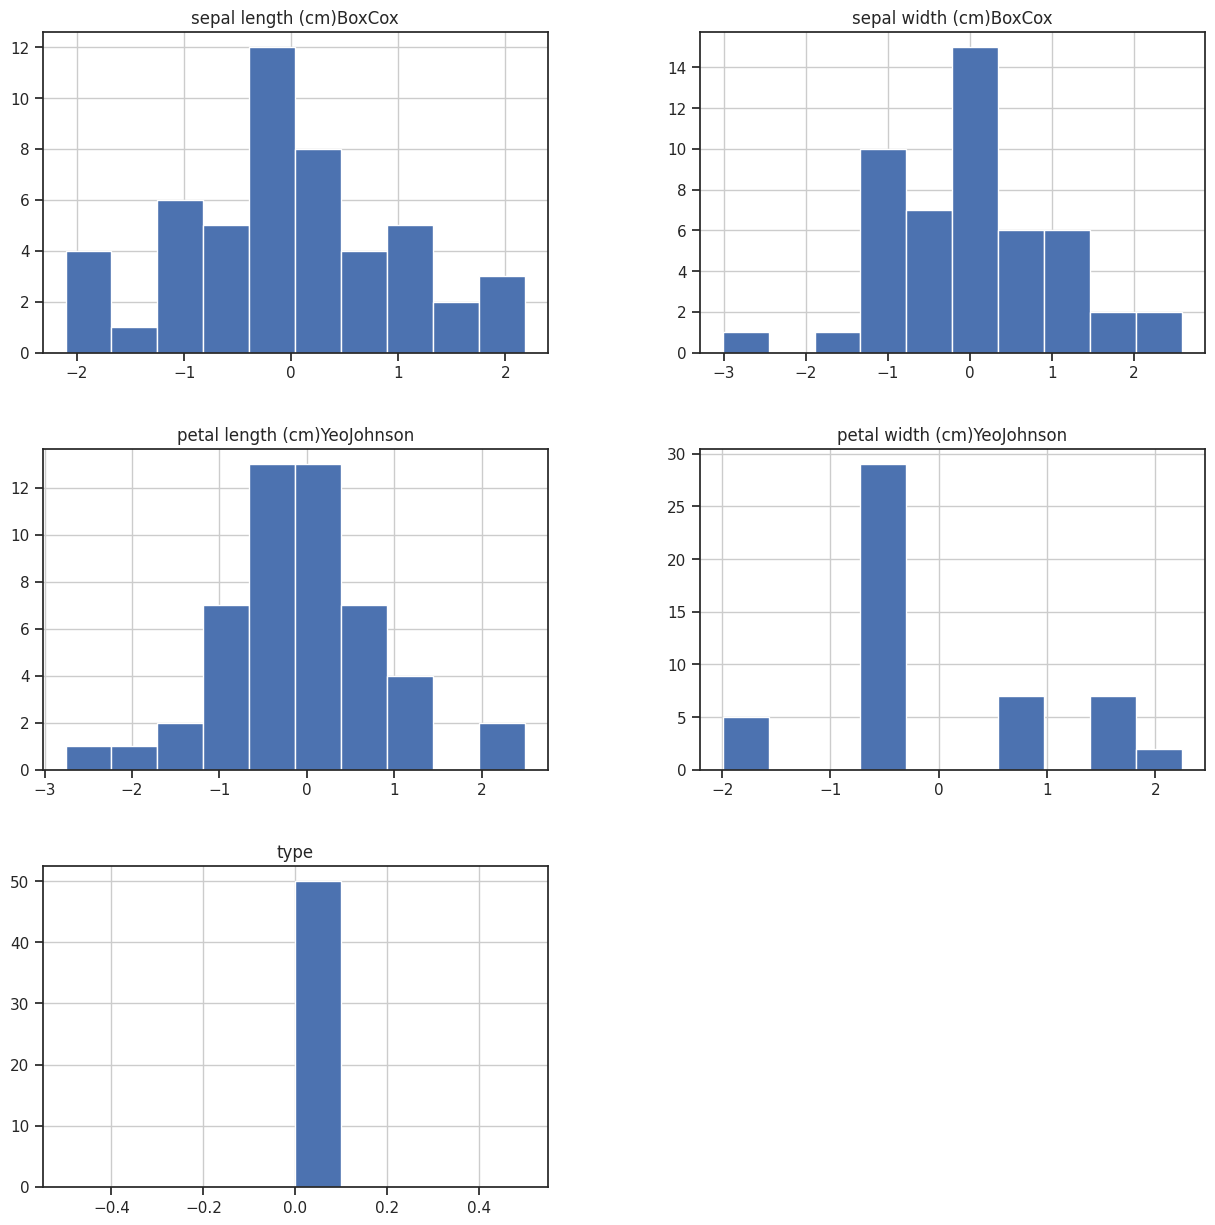

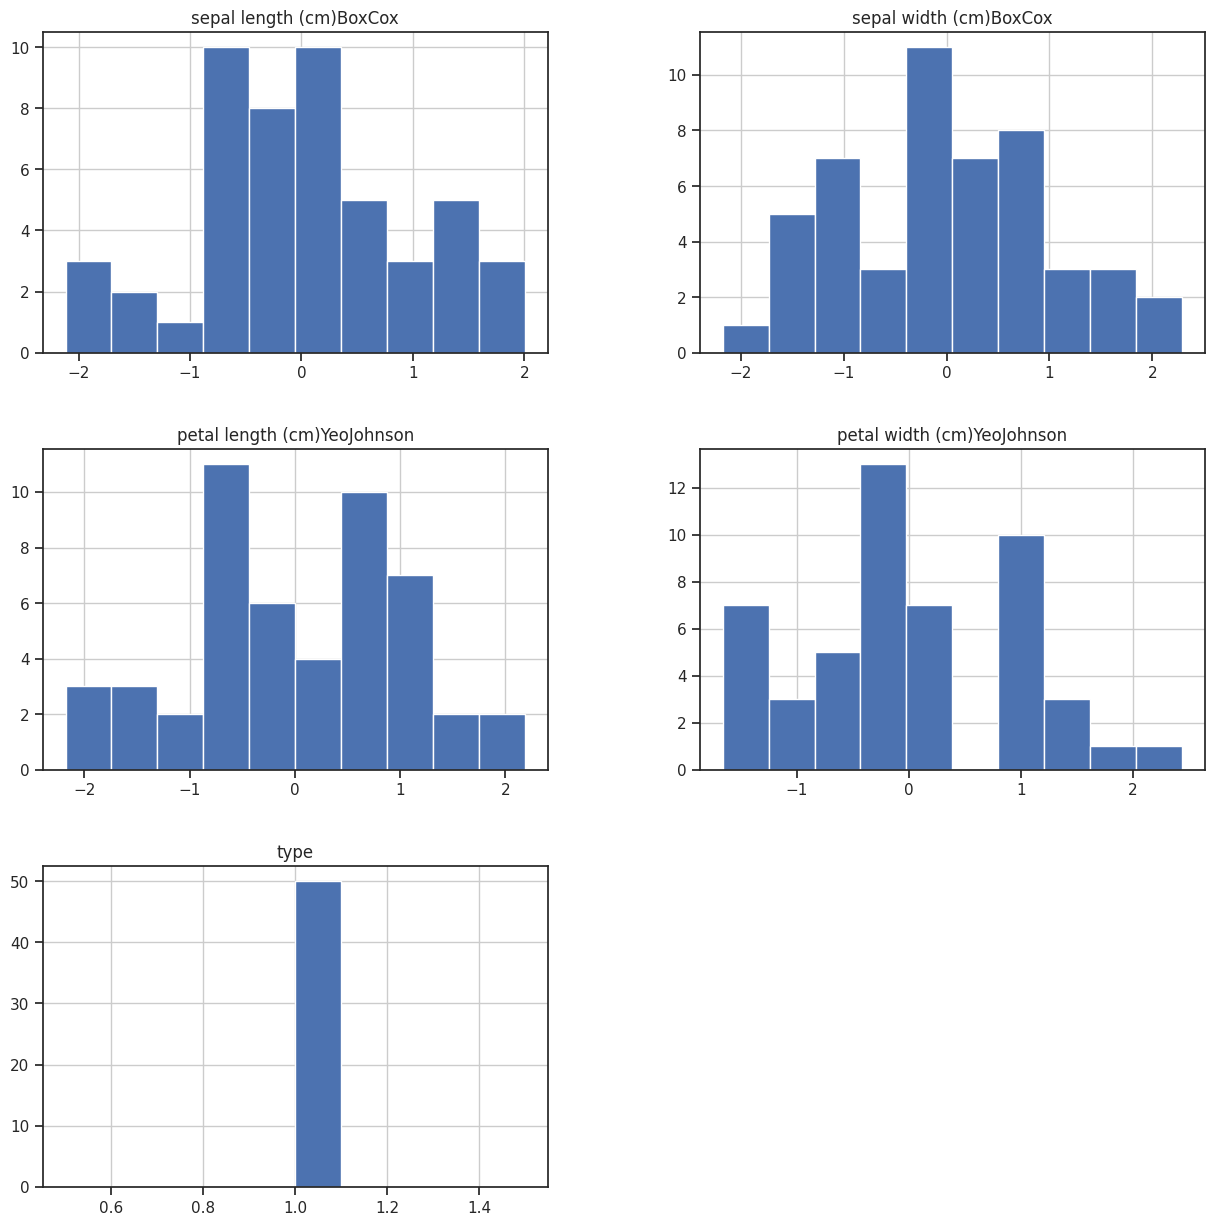

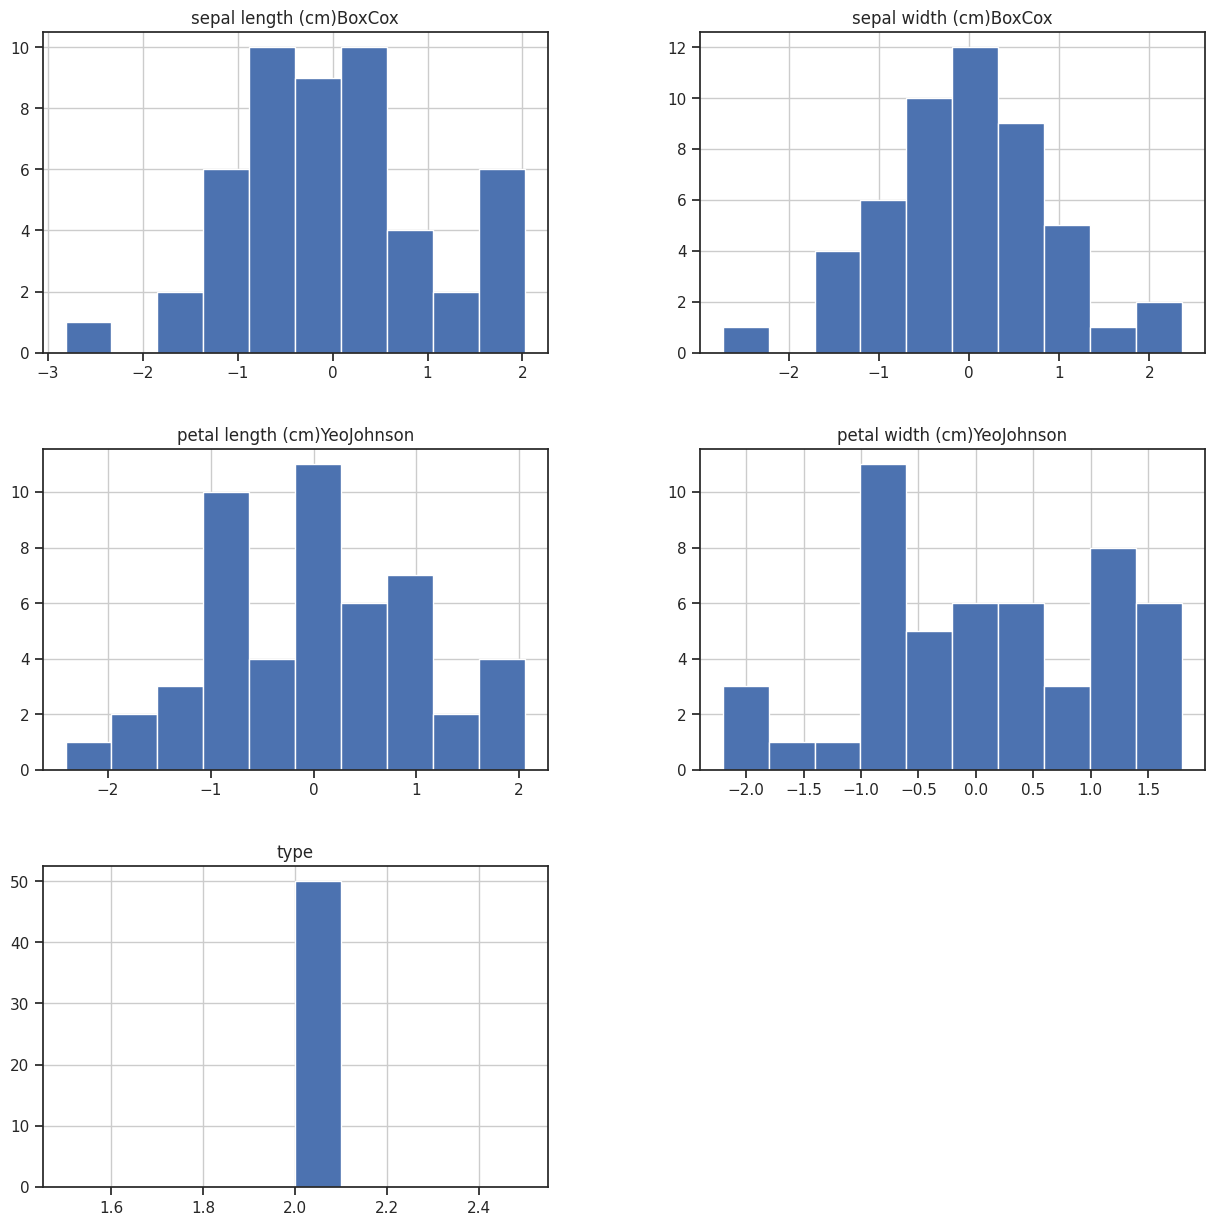

In [31]:
plt.rcParams["figure.figsize"] = (15,15)
dataModel.groupby(target).hist()

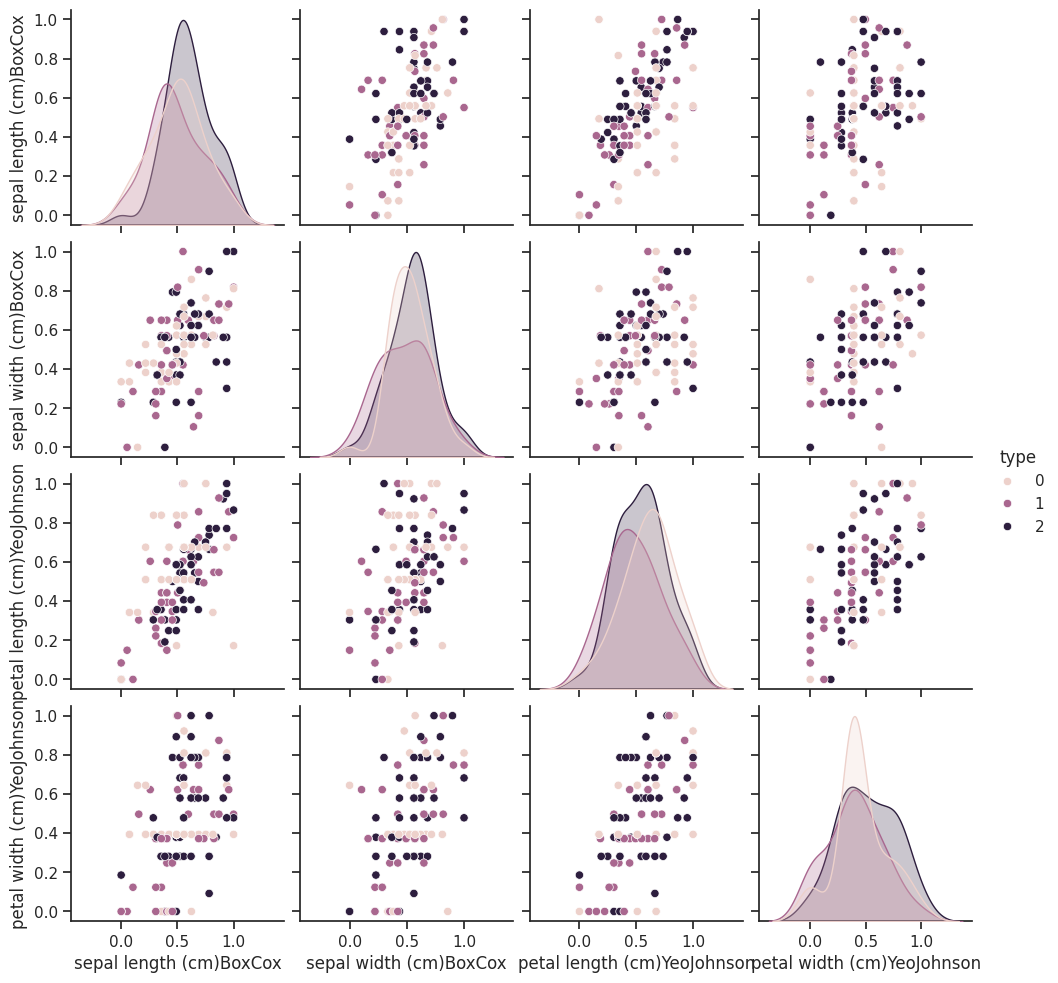

In [32]:
sns.set_theme(style="ticks")
sns.pairplot(dataTrain, hue=target)

<Axes: >

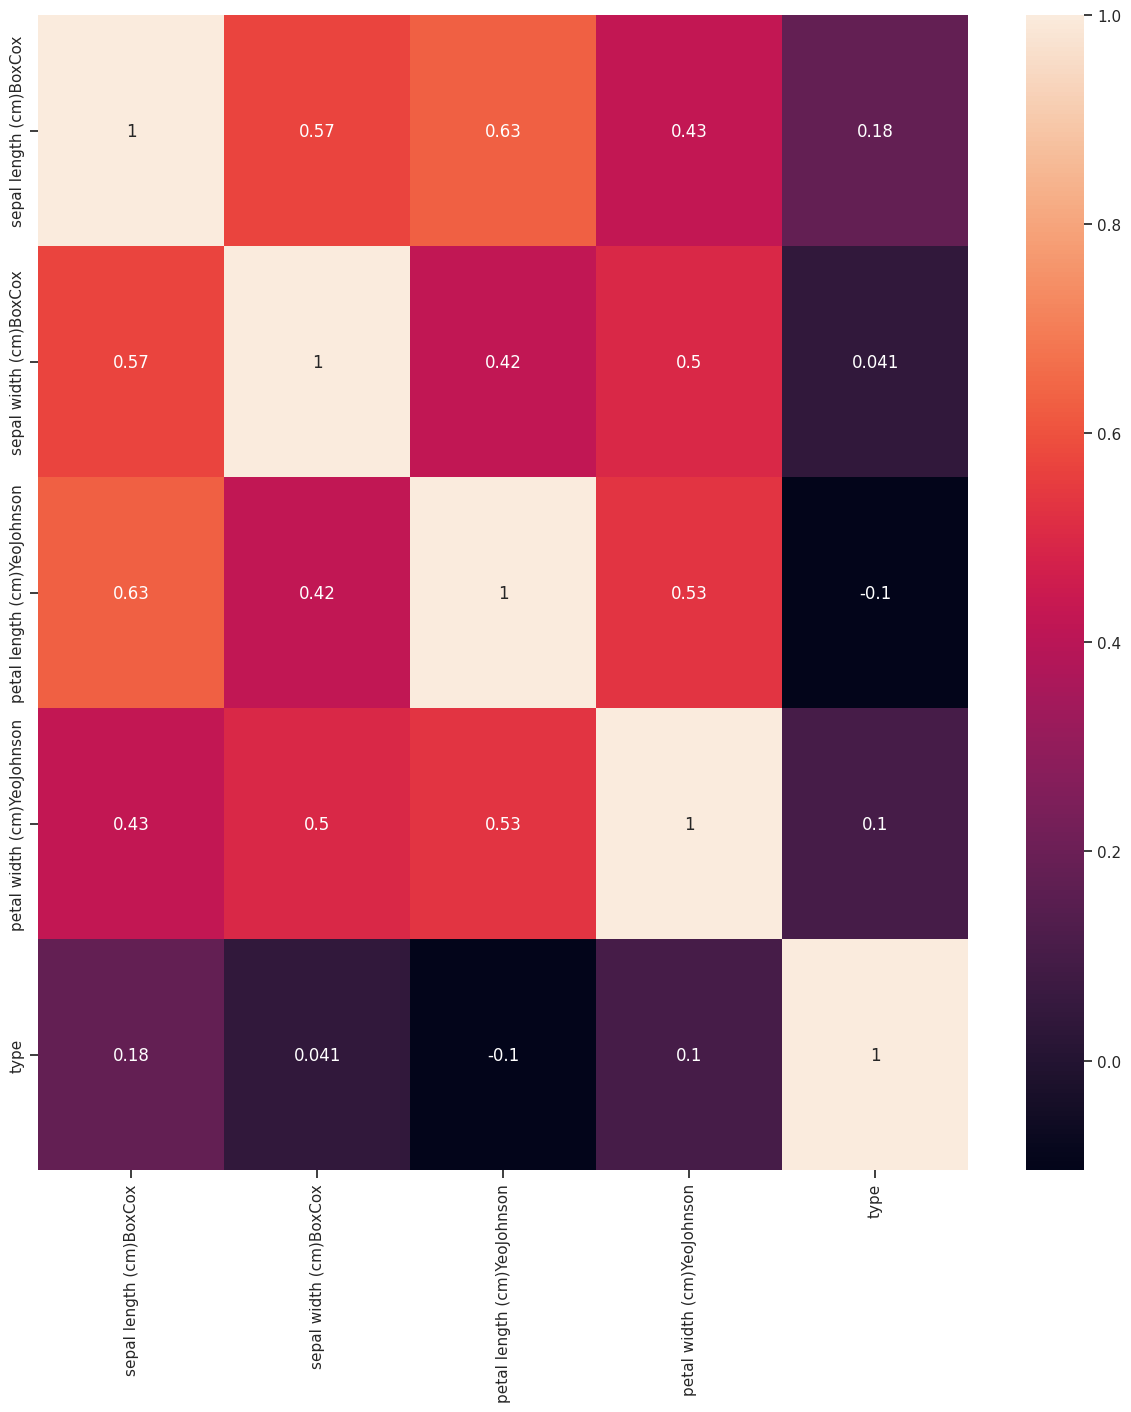

In [33]:
sns.heatmap(dataTrain.select_dtypes(np.number).corr(),annot=True)

In [34]:
y_train=dataTrain[target]
X_train=dataTrain.drop(target,axis=1)

In [35]:
X_train

,sepal length (cm)BoxCox,sepal width (cm)BoxCox,petal length (cm)YeoJohnson,petal width (cm)YeoJohnson
137,0.523064,0.622271,0.543886,0.281564
84,0.258222,0.649318,0.603265,0.622062
...,...,...,...,...
117,0.938588,1.000000,0.948944,0.681955
47,0.217578,0.430067,0.509546,0.393637


LDA

In [36]:
dataTrain[target].unique()

array([2, 1, 0])

In [37]:
lda = LinearDiscriminantAnalysis(n_components=1)
lda

LinearDiscriminantAnalysis(n_components=1)

In [38]:
X_trainLDA = lda.fit_transform(X_train, y_train)
X_testLDA = lda.transform(X_test)

In [39]:
y_train.value_counts()

type
2    44
0    39
1    37
Name: count, dtype: int64

In [40]:


kf = KFold(n_splits=5)
params = {
    "kernel" : list(["poly","rbf"]),
    "gamma" : list([0.01,0.05,0.1,0.15,0.2,0.3,0.5,0.8,1]),
    "C": list([0.01,0.05,0.1,0.15,0.2,0.3,0.5,0.8,1]),
    "random_state" :[0]
}


metricsTest={"precision_score":[],"recall_score":[],"accuracy_score":[],"f1_score":[]}
metricsTrain={"precision_score":[],"recall_score":[],"accuracy_score":[],"f1_score":[]}
indexTrain=[]
indexTest=[]
start = time.time()
grid_rf = GridSearchCV(SVC(),refit = True, verbose=50, param_grid=params, cv=KFold(n_splits=5), scoring="accuracy").fit(X_train, y_train)
end = time.time()
y_predTest = grid_rf.predict(X_test)
y_predTrain= grid_rf.predict(X_train)

metricsTest["recall_score"].append(recall_score(y_test, y_predTest,average="micro"))
metricsTest["precision_score"].append(precision_score(y_test, y_predTest,average="micro"))
metricsTest["f1_score"].append(f1_score(y_test, y_predTest,average="micro"))
metricsTest["accuracy_score"].append(accuracy_score(y_test, y_predTest))
metricsTrain["recall_score"].append(recall_score(y_train, y_predTrain,average="micro"))
metricsTrain["precision_score"].append(precision_score(y_train, y_predTrain,average="micro"))
metricsTrain["f1_score"].append(f1_score(y_train, y_predTrain,average="micro"))
metricsTrain["accuracy_score"].append(accuracy_score(y_train, y_predTrain))

indexTrain.append("Train (Time: "+f'{end-start})')
indexTest.append("Test")

metrics=pd.DataFrame(metricsTrain)
metrics1=pd.DataFrame(metricsTest)
metrics.index=indexTrain
metrics1.index=indexTest




Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 1/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.208 total time=   0.0s
[CV 2/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 2/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.375 total time=   0.0s
[CV 3/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 3/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.083 total time=   0.0s
[CV 4/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 4/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.292 total time=   0.0s
[CV 5/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 5/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.292 total time=   0.0s
[CV 1/5; 2/162] START C=0.0

In [41]:


kf = KFold(n_splits=5)
params = {
    "kernel" : list(["poly","rbf"]),
    "gamma" : list([0.01,0.05,0.1,0.15,0.2,0.3,0.5,0.8,1]),
    "C": list([0.01,0.05,0.1,0.15,0.2,0.3,0.5,0.8,1]),
    "random_state" :[0]
}


metricsTest={"precision_score":[],"recall_score":[],"accuracy_score":[],"f1_score":[]}
metricsTrain={"precision_score":[],"recall_score":[],"accuracy_score":[],"f1_score":[]}
indexTrain=[]
indexTest=[]
start = time.time()
grid_rf = GridSearchCV(SVC(),refit = True, verbose=50, param_grid=params, cv=KFold(n_splits=5), scoring="accuracy").fit(X_trainLDA, y_train)
end = time.time()
y_predTest = grid_rf.predict(X_testLDA)
y_predTrain= grid_rf.predict(X_trainLDA)

metricsTest["recall_score"].append(recall_score(y_test, y_predTest,average="micro"))
metricsTest["precision_score"].append(precision_score(y_test, y_predTest,average="micro"))
metricsTest["f1_score"].append(f1_score(y_test, y_predTest,average="micro"))
metricsTest["accuracy_score"].append(accuracy_score(y_test, y_predTest))
metricsTrain["recall_score"].append(recall_score(y_train, y_predTrain,average="micro"))
metricsTrain["precision_score"].append(precision_score(y_train, y_predTrain,average="micro"))
metricsTrain["f1_score"].append(f1_score(y_train, y_predTrain,average="micro"))
metricsTrain["accuracy_score"].append(accuracy_score(y_train, y_predTrain))

indexTrain.append("Train (Time: "+f'{end-start})')
indexTest.append("Test")

metrics2=pd.DataFrame(metricsTrain)
metrics3=pd.DataFrame(metricsTest)
metrics2.index=indexTrain
metrics3.index=indexTest




Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV 1/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 1/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.417 total time=   0.0s
[CV 2/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 2/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.375 total time=   0.0s
[CV 3/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 3/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.083 total time=   0.0s
[CV 4/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 4/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.292 total time=   0.0s
[CV 5/5; 1/162] START C=0.01, gamma=0.01, kernel=poly, random_state=0...........
[CV 5/5; 1/162] END C=0.01, gamma=0.01, kernel=poly, random_state=0;, score=0.292 total time=   0.0s
[CV 1/5; 2/162] START C=0.0

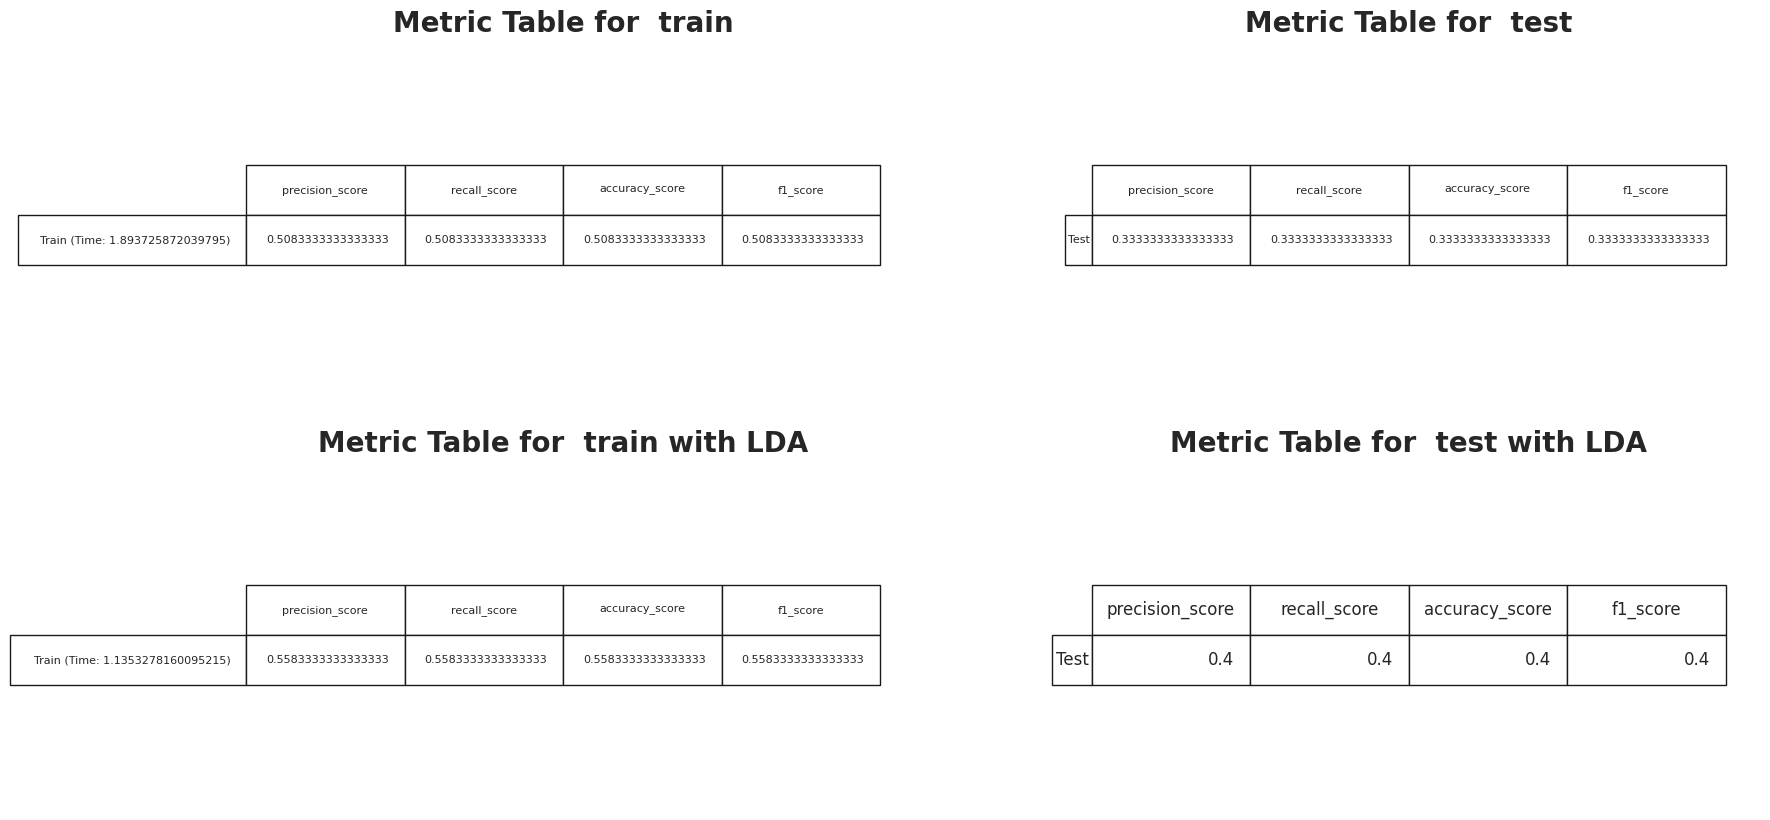

In [45]:
plt.rcParams["figure.figsize"] = (20,10)
fix, ax = plt.subplots(nrows=2, ncols=2)
ax[0][0].axis("off")
ax[0][0].axis('tight')
ax[0][0].set_title(f"Metric Table for  train", weight='bold',fontsize=20)
ax[0][0].table(cellText=metrics.to_numpy(),rowLabels=metrics.index.tolist(),colLabels=metrics.columns.tolist(),loc='center').scale(0.9,3)


ax[0][1].axis("off")
ax[0][1].axis('tight')
ax[0][1].set_title(f"Metric Table for  test", weight='bold',fontsize=20)
ax[0][1].table(cellText=metrics1.to_numpy(),rowLabels=metrics1.index.tolist(),colLabels=metrics1.columns.tolist(),loc='center').scale(0.9,3)

ax[1][0].axis("off")
ax[1][0].axis('tight')
ax[1][0].set_title(f"Metric Table for  train with LDA", weight='bold',fontsize=20)
ax[1][0].table(cellText=metrics2.to_numpy(),rowLabels=metrics2.index.tolist(),colLabels=metrics2.columns.tolist(),loc='center').scale(0.9,3)


ax[1][1].axis("off")
ax[1][1].axis('tight')
ax[1][1].set_title(f"Metric Table for  test with LDA", weight='bold',fontsize=20)
ax[1][1].table(cellText=metrics3.to_numpy(),rowLabels=metrics3.index.tolist(),colLabels=metrics3.columns.tolist(),loc='center').scale(0.9,3)